<a href="https://colab.research.google.com/github/YassminWalid784/image/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import imgaug.augmenters as iaa
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import plotly.express as px
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  Add, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, GlobalMaxPooling2D,Lambda,MaxPooling2D, GlobalAveragePooling2D,UpSampling2D,concatenate,Multiply,Conv2DTranspose,AvgPool2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#K.set_image_data_format('channels_last')
#K.set_learning_phase(1)
#tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! ls

'kaggle (1).json'   sample_data


In [ ]:
import zipfile
patient_data = zipfile.ZipFile('/content/lgg-mri-segmentation.zip', 'r')
patient_data.extractall('files')
patient_data.close()

# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
patient_data = pd.read_csv('/content/files/lgg-mri-segmentation/kaggle_3m/data.csv')

In [ ]:
# Make objects with the images and masks. 
brain_scans = []
mask_files = glob.glob('/content/files/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# Data Preprocessing

In [ ]:
for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:10])
print(mask_files[:10])

['/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_26.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_17.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_37.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_38.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_13.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_9.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_25.tif', '/content/files/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_34.tif']


In [ ]:
#get information
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
# This shows the first 5 rows of the patient data
patient_data.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [ ]:
#see if there is null values or not
patient_data.isnull().sum()

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

In [ ]:
#impute missing values in the patient_data dataset using KNNImputer
k=patient_data.columns
imputer = KNNImputer(n_neighbors=4)
x=pd.DataFrame(np.round(imputer.fit_transform(patient_data.drop('Patient',axis=1))),columns=k[1:])
for i in k[1:]:
  patient_data[i]=x[i]

In [ ]:
#show data
patient_data

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0    TCGA_CS_4941            2.0                 4.0           2.0        2.0   
1    TCGA_CS_4942            1.0                 5.0           2.0        1.0   
2    TCGA_CS_4943            1.0                 5.0           2.0        1.0   
3    TCGA_CS_4944            2.0                 5.0           2.0        1.0   
4    TCGA_CS_5393            4.0                 5.0           2.0        1.0   
..            ...            ...                 ...           ...        ...   
105  TCGA_HT_8563            2.0                 5.0           3.0        1.0   
106  TCGA_HT_A5RC            2.0                 4.0           2.0        2.0   
107  TCGA_HT_A616            1.0                 5.0           2.0        1.0   
108  TCGA_HT_A61A            2.0                 5.0           2.0        1.0   
109  TCGA_HT_A61B            3.0                 5.0           2.0        1.0   

     RPPACluster  OncosignCluster  COCCluster  histological_type  \
0            4.0              3.0         2.0                1.0   
1            1.0              2.0         1.0                1.0   
2            2.0              2.0         1.0                1.0   
3            2.0              1.0         1.0                1.0   
4            2.0              3.0         1.0                1.0   
..           ...              ...         ...                ...   
105          2.0              2.0         2.0                1.0   
106          4.0              3.0         2.0                1.0   
107          2.0              2.0         1.0                1.0   
108          3.0              2.0         1.0                3.0   
109          1.0              2.0         1.0                2.0   

     neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                          2.0                1.0         3.0             2.0   
1                          2.0                1.0         3.0             2.0   
2                          2.0                1.0         1.0             2.0   
3                          1.0                1.0         3.0             6.0   
4                          2.0                1.0         1.0             6.0   
..                         ...                ...         ...             ...   
105                        2.0                1.0         3.0             2.0   
106                        2.0                1.0         1.0             2.0   
107                        1.0                1.0         1.0             2.0   
108                        1.0                1.0         1.0             6.0   
109                        1.0                1.0         2.0             3.0   

     gender  age_at_initial_pathologic  race  ethnicity  death01  
0       2.0                       67.0   3.0        2.0      1.0  
1       1.0                       44.0   2.0        2.0      1.0  
2       2.0                       37.0   3.0        2.0      0.0  
3       2.0                       50.0   3.0        2.0      0.0  
4       2.0                       39.0   3.0        2.0      0.0  
..      ...                        ...   ...        ...      ...  
105     1.0                       30.0   3.0        2.0      0.0  
106     1.0                       70.0   3.0        2.0      1.0  
107     1.0                       36.0   3.0        2.0      0.0  
108     1.0                       20.0   3.0        2.0      0.0  
109     2.0                       40.0   3.0        2.0      0.0  

[110 rows x 18 columns]

In [ ]:
#PLOT AGE OF PATIENTS
age_counts = patient_data["age_at_initial_pathologic"].value_counts()
fig = px.bar(age_counts, title="Age of patients")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

<AxesSubplot:>

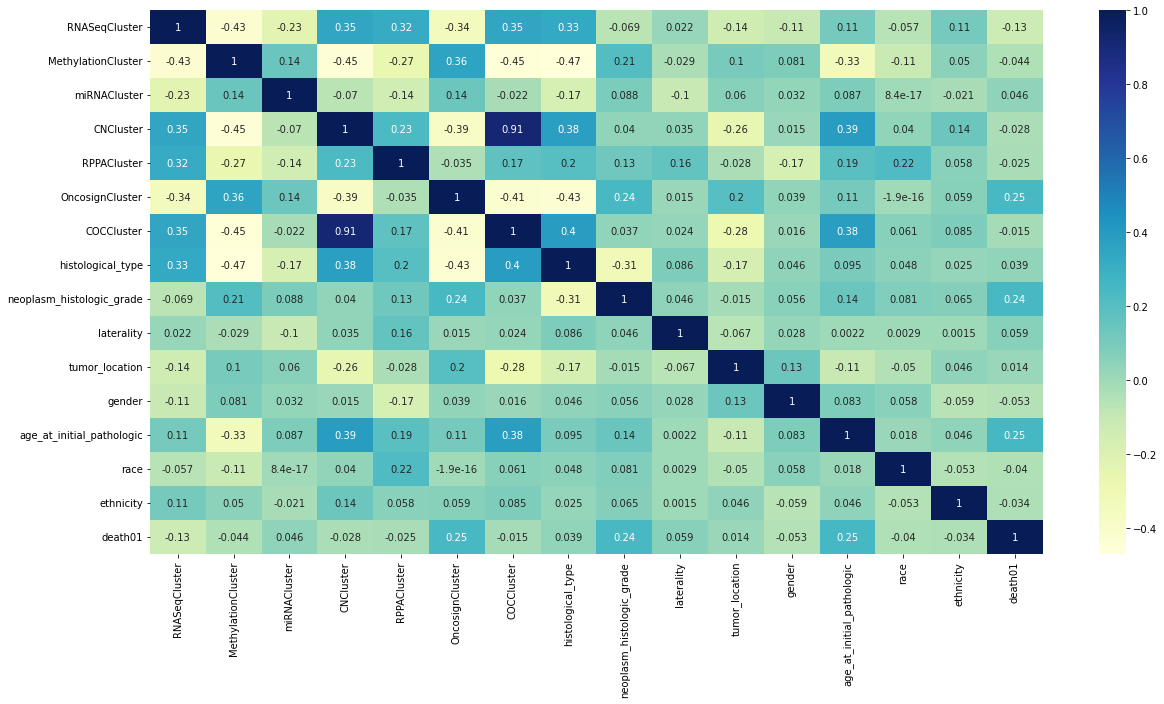

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(patient_data.drop('tumor_tissue_site',axis=1).corr(), cmap="YlGnBu", annot=True)#tumor tissue site contains same value throughout thus is dropped

In [ ]:
# Make objects with the images and masks. 
df=pd.DataFrame()
df['img']=brain_scans
df['mask']=mask_files

In [ ]:
#determine the label of an image based on its mask
def labels(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

In [ ]:
df['label']=df['mask'].apply(labels)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='label', ylabel='count'>

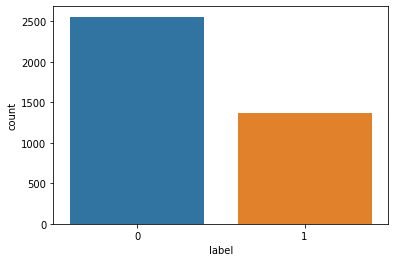

In [ ]:
#plot the label of an image 
sns.countplot(df.label)

In [ ]:
#takes a path string as an argument, splits it by '/' to get the file name, then splits the file name
def path(x):
  y=x.split("/")[-1]
  z=y.split(".")[0]
  z1=z.split("_")
  return "_".join(z1[:-2])
df['Patient']=df.img.apply(path)

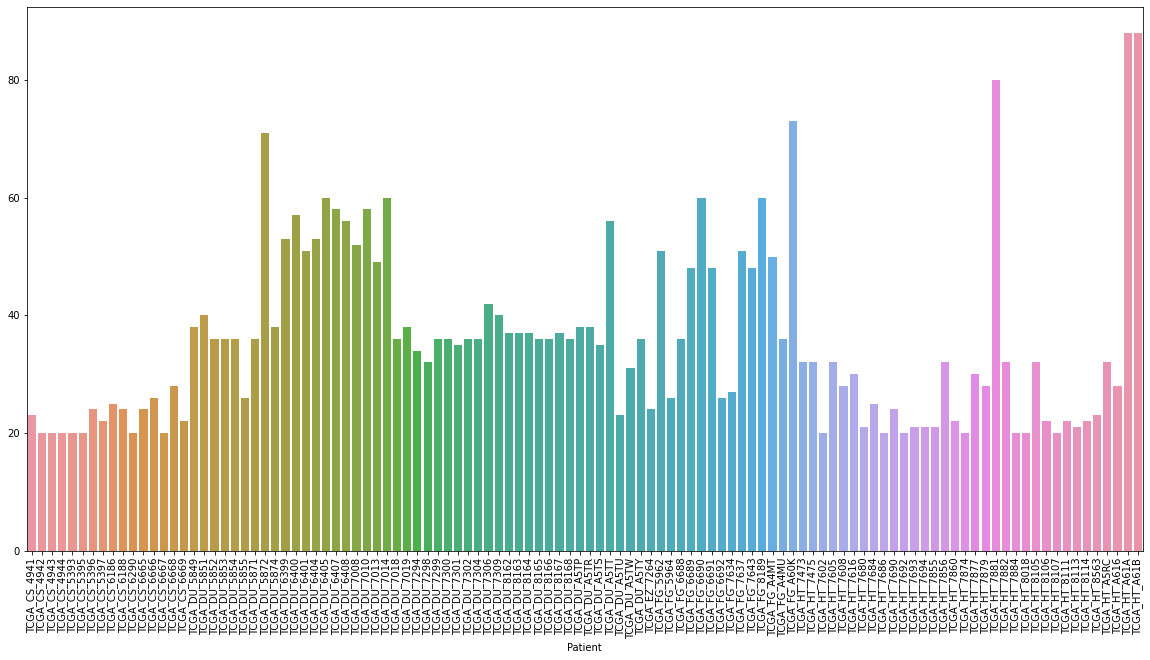

In [ ]:
k=df.groupby(df.Patient)
l=k.size()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x=l.index,y=l.values)
plt.show()

In [ ]:
df['labmsk']=df['label'].apply(lambda x: str(x))

In [ ]:
Data=pd.merge(df, patient_data, how='inner', left_on = 'Patient', right_on = 'Patient')
Data.head(10)

img  \
0  /content/files/lgg-mri-segmentation/kaggle_3m/...   
1  /content/files/lgg-mri-segmentation/kaggle_3m/...   
2  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3  /content/files/lgg-mri-segmentation/kaggle_3m/...   
4  /content/files/lgg-mri-segmentation/kaggle_3m/...   
5  /content/files/lgg-mri-segmentation/kaggle_3m/...   
6  /content/files/lgg-mri-segmentation/kaggle_3m/...   
7  /content/files/lgg-mri-segmentation/kaggle_3m/...   
8  /content/files/lgg-mri-segmentation/kaggle_3m/...   
9  /content/files/lgg-mri-segmentation/kaggle_3m/...   

                                                mask  label       Patient  \
0  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
1  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
2  /content/files/lgg-mri-segmentation/kaggle_3m/...      0  TCGA_DU_6401   
3  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
4  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
5  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
6  /content/files/lgg-mri-segmentation/kaggle_3m/...      0  TCGA_DU_6401   
7  /content/files/lgg-mri-segmentation/kaggle_3m/...      0  TCGA_DU_6401   
8  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   
9  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  TCGA_DU_6401   

  labmsk  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0      1            1.0                 5.0           2.0        1.0   
1      1            1.0                 5.0           2.0        1.0   
2      0            1.0                 5.0           2.0        1.0   
3      1            1.0                 5.0           2.0        1.0   
4      1            1.0                 5.0           2.0        1.0   
5      1            1.0                 5.0           2.0        1.0   
6      0            1.0                 5.0           2.0        1.0   
7      0            1.0                 5.0           2.0        1.0   
8      1            1.0                 5.0           2.0        1.0   
9      1            1.0                 5.0           2.0        1.0   

   RPPACluster  ...  histological_type  neoplasm_histologic_grade  \
0          2.0  ...                3.0                        1.0   
1          2.0  ...                3.0                        1.0   
2          2.0  ...                3.0                        1.0   
3          2.0  ...                3.0                        1.0   
4          2.0  ...                3.0                        1.0   
5          2.0  ...                3.0                        1.0   
6          2.0  ...                3.0                        1.0   
7          2.0  ...                3.0                        1.0   
8          2.0  ...                3.0                        1.0   
9          2.0  ...                3.0                        1.0   

   tumor_tissue_site  laterality  tumor_location  gender  \
0                1.0         1.0             2.0     1.0   
1                1.0         1.0             2.0     1.0   
2                1.0         1.0             2.0     1.0   
3                1.0         1.0             2.0     1.0   
4                1.0         1.0             2.0     1.0   
5                1.0         1.0             2.0     1.0   
6                1.0         1.0             2.0     1.0   
7                1.0         1.0             2.0     1.0   
8                1.0         1.0             2.0     1.0   
9                1.0         1.0             2.0     1.0   

   age_at_initial_pathologic  race  ethnicity  death01  
0                       31.0   3.0        2.0      1.0  
1                       31.0   3.0        2.0      1.0  
2                       31.0   3.0        2.0      1.0  
3                       31.0   3.0        2.0      1.0  
4                       31.0   3.0        2.0      1.0  
5                       31.0

In [ ]:
# Make a dataframe with the images and their corresponding masks
data_img = pd.DataFrame({"image_path":brain_scans,"mask_path":mask_files})

In [ ]:
# Make a function that search for the largest pixel value in the masks, because that will indicate if the image have 
# a corresponding mask with a tumor or not. 
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0
    
# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicate no tumor and 1 a tumor. 
data_img["Tumor"] = data_img["mask_path"].apply(lambda x: positive_negative_diagnosis(x)) 

In [ ]:
# showing the data
data_img 

image_path  \
0     /content/files/lgg-mri-segmentation/kaggle_3m/...   
1     /content/files/lgg-mri-segmentation/kaggle_3m/...   
2     /content/files/lgg-mri-segmentation/kaggle_3m/...   
3     /content/files/lgg-mri-segmentation/kaggle_3m/...   
4     /content/files/lgg-mri-segmentation/kaggle_3m/...   
...                                                 ...   
3924  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3925  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3926  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3927  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3928  /content/files/lgg-mri-segmentation/kaggle_3m/...   

                                              mask_path  Tumor  
0     /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
1     /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
2     /content/files/lgg-mri-segmentation/kaggle_3m/...      0  
3     /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
4     /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
...                                                 ...    ...  
3924  /content/files/lgg-mri-segmentation/kaggle_3m/...      0  
3925  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
3926  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
3927  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  
3928  /content/files/lgg-mri-segmentation/kaggle_3m/...      1  

[3929 rows x 3 columns]

# 2. DATA VISUALISATION

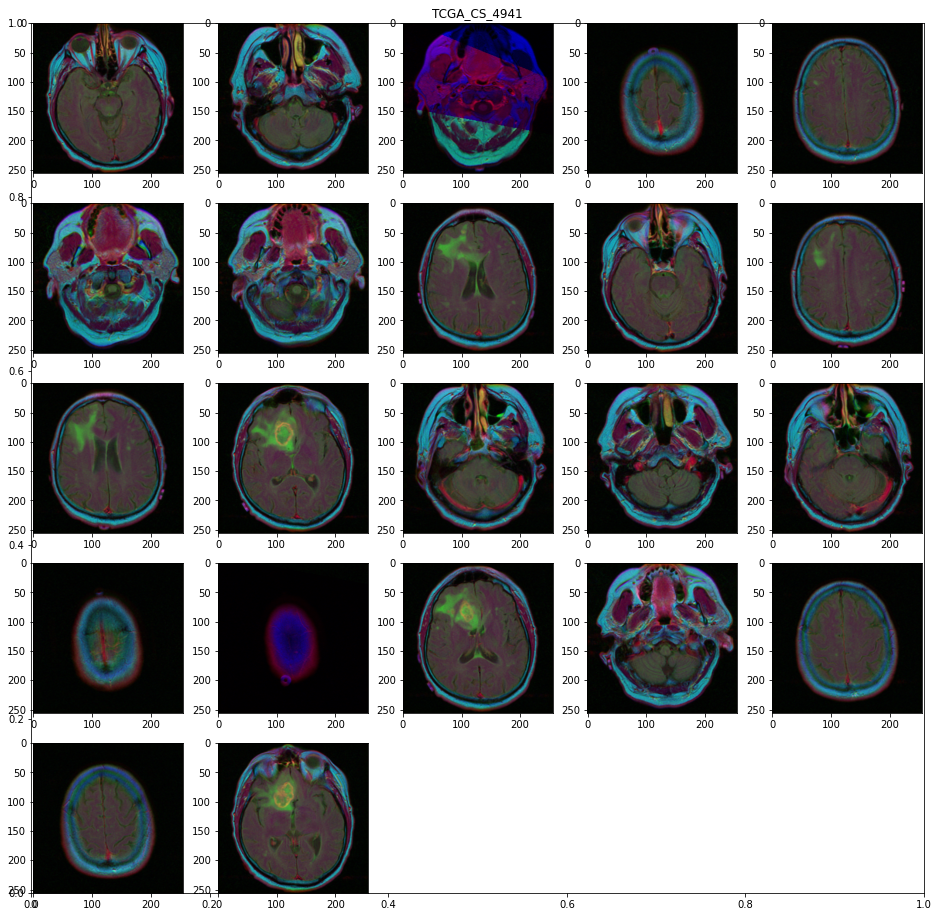

In [ ]:
#reads in an image and its corresponding mask from a dataframe
rows,cols=5,5
l=k.get_group('TCGA_CS_4941')
fig=plt.figure(figsize=(16,16))
plt.title('TCGA_CS_4941')
for i in range(1,l.shape[0]):
    fig.add_subplot(rows,cols,i)
    img=cv2.imread(l['img'].iloc[i], cv2.IMREAD_UNCHANGED)
    msk_path=l['mask'].iloc[i]
    img=img/255
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    #plt.imshow(msk,alpha=0.5)
plt.show()

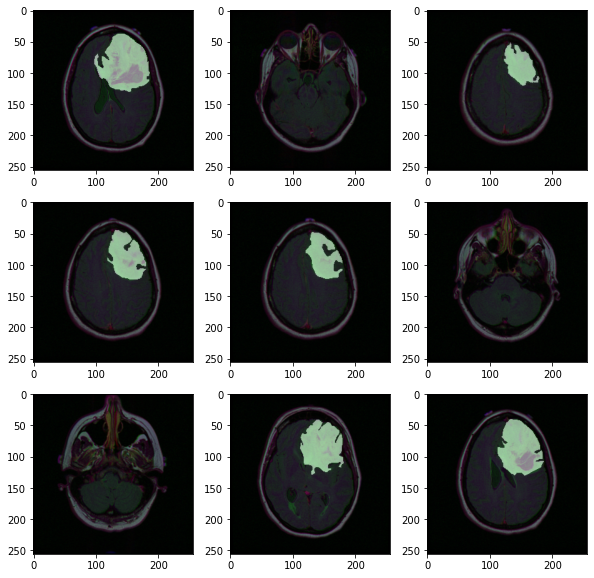

In [ ]:
rows,cols=3,3

fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=df['img'].iloc[i]
    msk_path=df['mask'].iloc[i]
    img=cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)
    #plt.title(df['img'].iloc[i])

plt.show()

In [ ]:
# How many non-tumors (0) and tumors (1)
data_img['Tumor'].value_counts()

0    2556
1    1373
Name: Tumor, dtype: int64

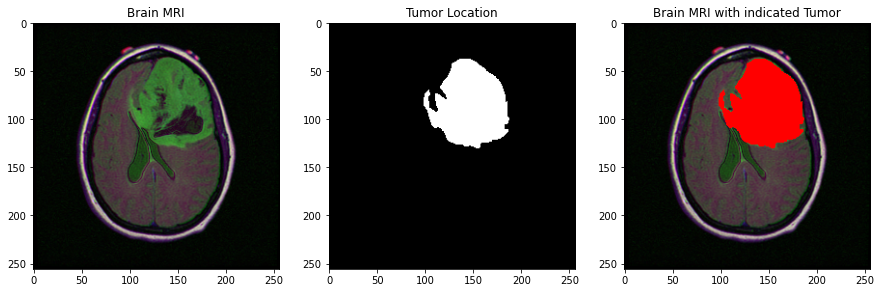

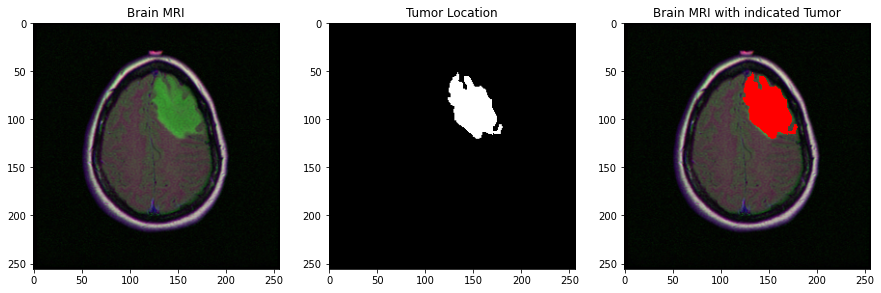

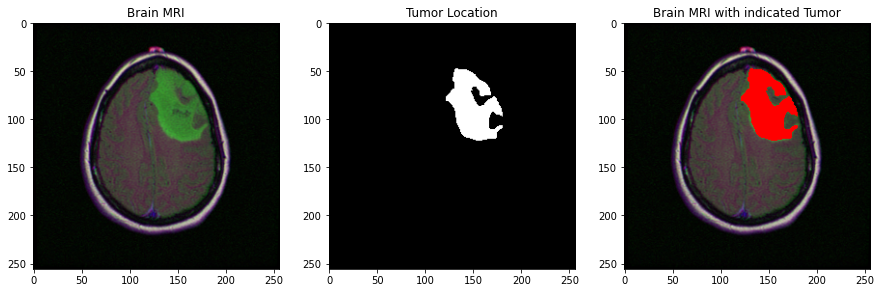

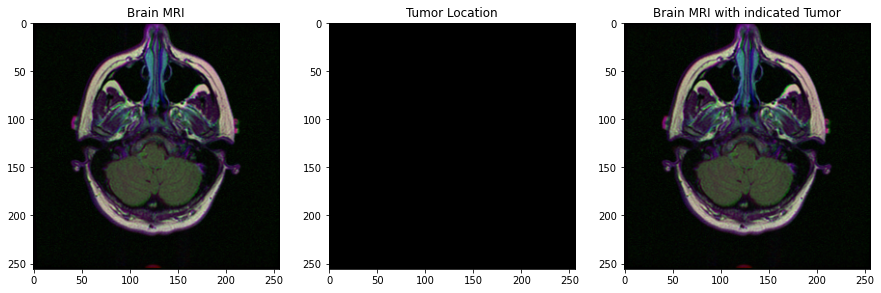

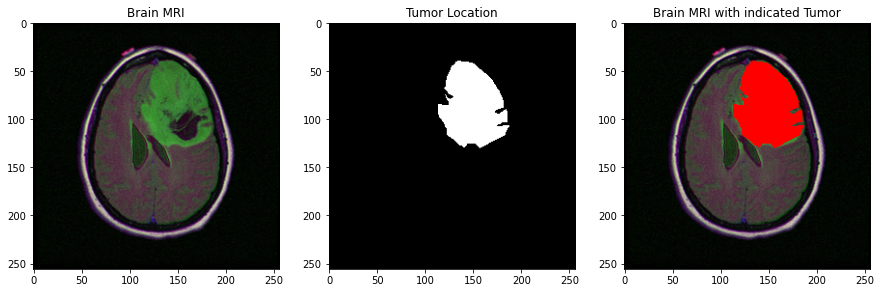

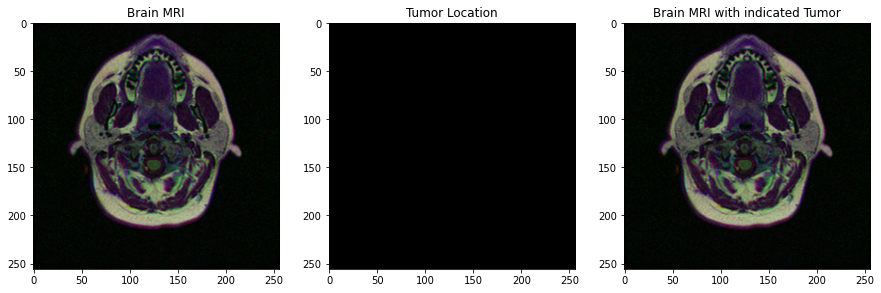

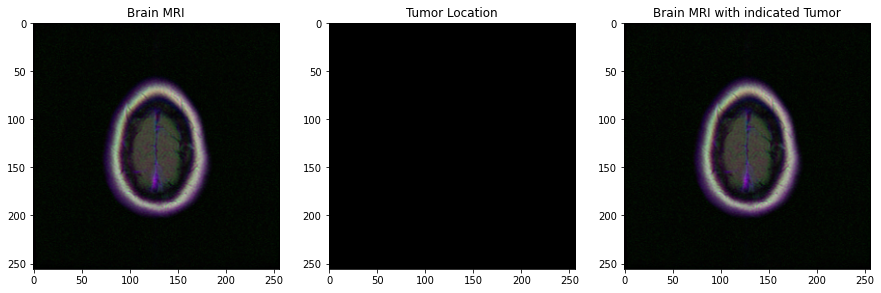

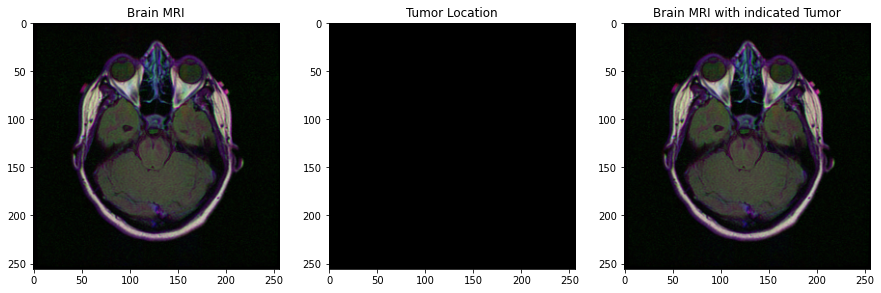

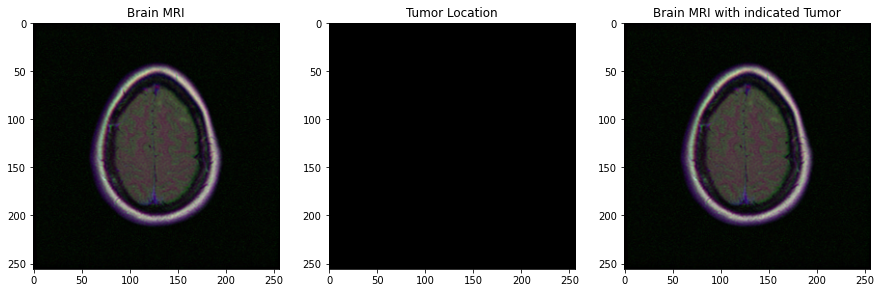

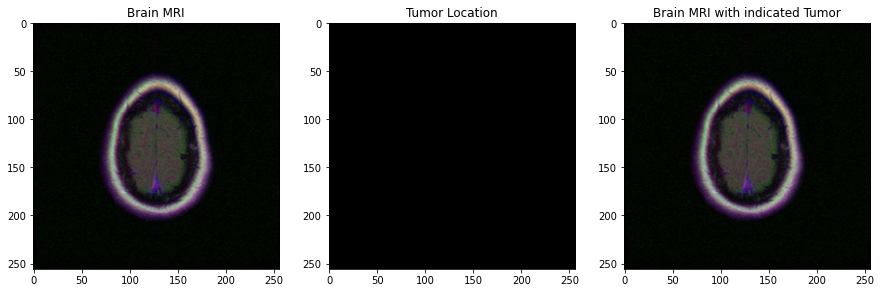

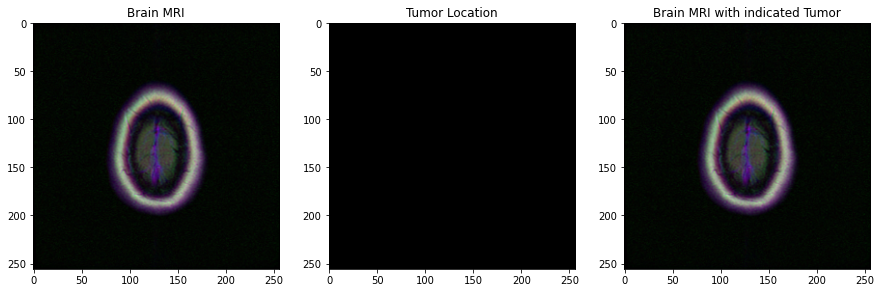

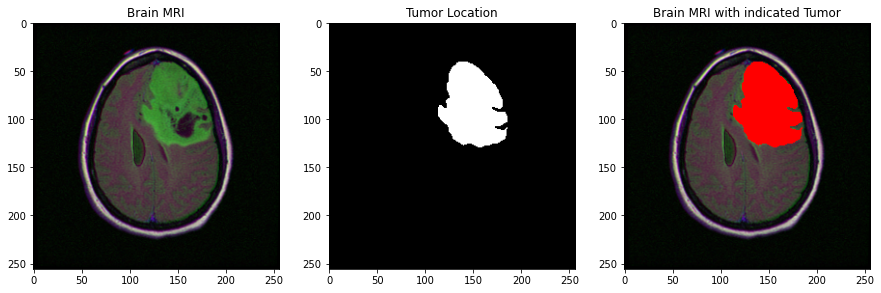

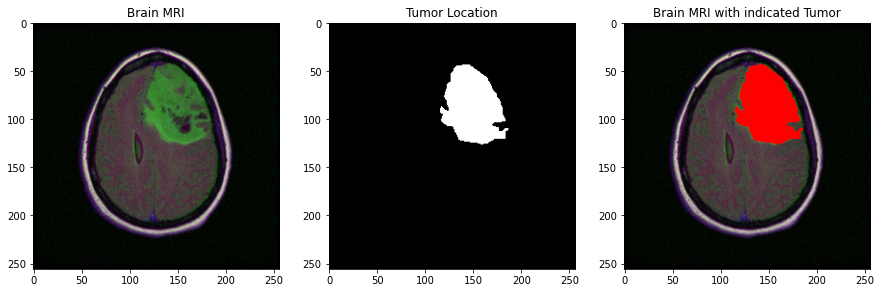

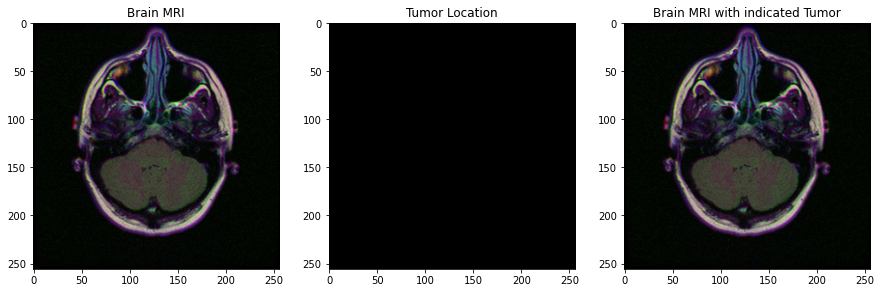

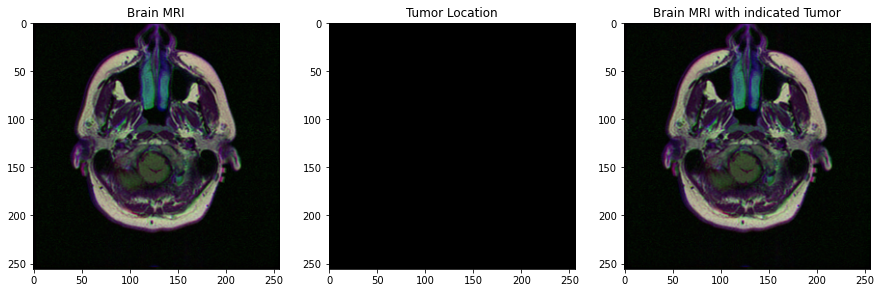

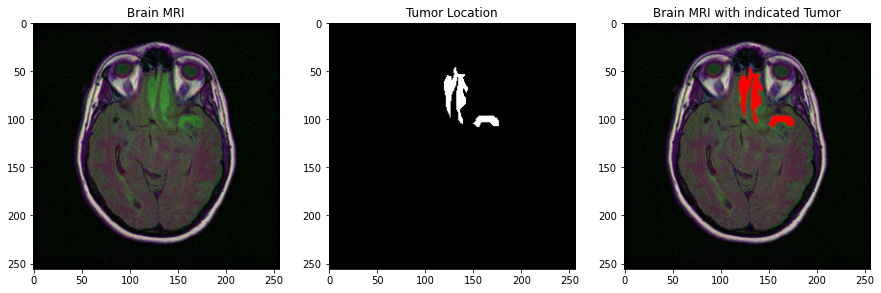

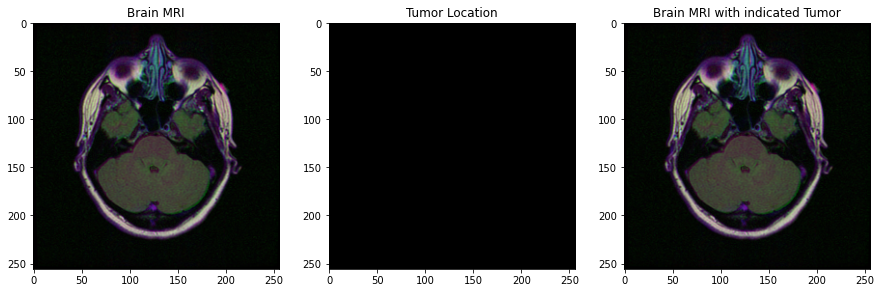

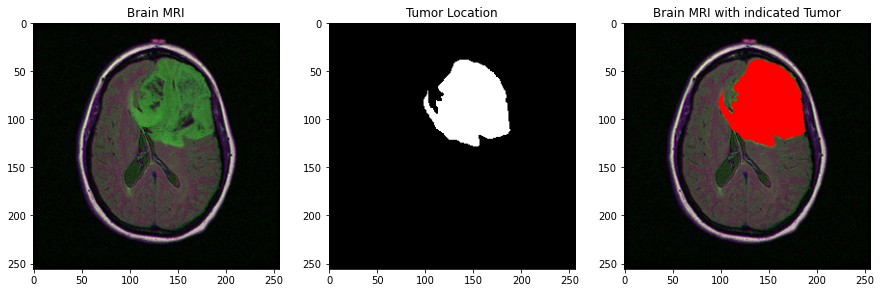

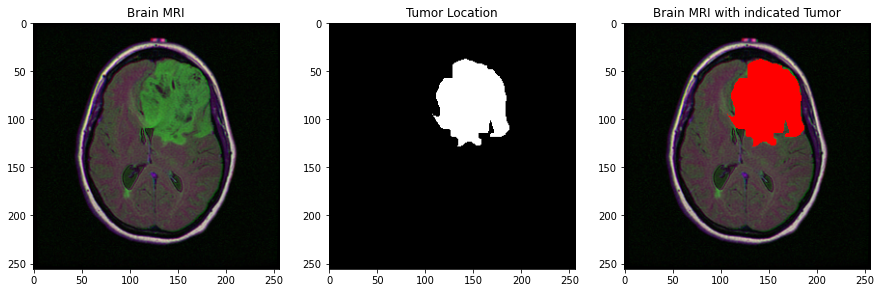

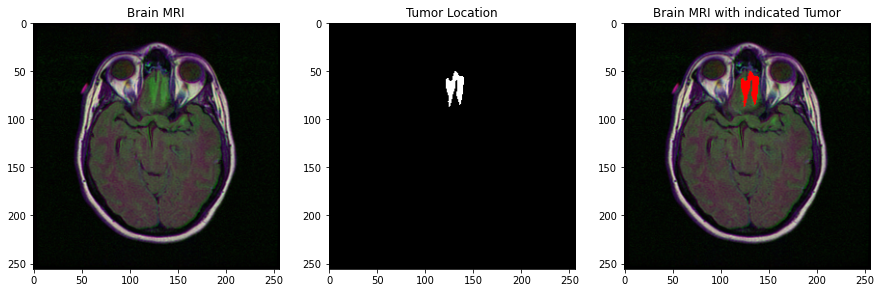

In [ ]:
for i in range(1,40, 2):
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)

    #Plot the Brain MRI scans 
    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")
   
    # Plot the corresponding mask
    main = original.copy()
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title("Tumor Location")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[2].imshow(sample_over_gt)
    ax[2].set_title("Brain MRI with indicated Tumor")

    

# Creating Test/Train/Validation

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
data_img['Tumor'] = data_img['Tumor'].apply(lambda x: str(x))
data_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   Tumor       3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
train, test = train_test_split(data_img,test_size = 0.1)
train, val = train_test_split(train,test_size = 0.2)
print(train.values.shape)
print(val.values.shape)
print(test.values.shape)

(2828, 3)
(708, 3)
(393, 3)


In [ ]:
train.head()
val.head()

image_path  \
1646  /content/files/lgg-mri-segmentation/kaggle_3m/...   
922   /content/files/lgg-mri-segmentation/kaggle_3m/...   
2068  /content/files/lgg-mri-segmentation/kaggle_3m/...   
3157  /content/files/lgg-mri-segmentation/kaggle_3m/...   
2221  /content/files/lgg-mri-segmentation/kaggle_3m/...   

                                              mask_path Tumor  
1646  /content/files/lgg-mri-segmentation/kaggle_3m/...     0  
922   /content/files/lgg-mri-segmentation/kaggle_3m/...     1  
2068  /content/files/lgg-mri-segmentation/kaggle_3m/...     0  
3157  /content/files/lgg-mri-segmentation/kaggle_3m/...     0  
2221  /content/files/lgg-mri-segmentation/kaggle_3m/...     0

### Visualize Number of the tumors are in the train, validation and test

In [ ]:
import plotly.graph_objects as go  # using plotly to create interactive plots
fig = go.Figure([go.Bar(x=train['Tumor'].value_counts().index, 
                        y=train['Tumor'].value_counts(), width=[.4, .4],)])
fig.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7)

fig.update_layout(title_text="Tumor Count Train",width=700,height=550,yaxis=dict(title_text="Count",tickmode="array",titlefont=dict(size=20)))

fig.update_yaxes(range = list([0,2000]))
fig.update_xaxes(tick0 = 0, dtick = 1)

fig.show()

In [ ]:
fig2 = go.Figure([go.Bar(x=val['Tumor'].value_counts().index, 
                        y=val['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig2.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig2.update_layout(title_text="Tumor Count Validation",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)))

fig2.update_yaxes(range = list([0,2000]))
fig2.update_xaxes(tick0 = 0, dtick = 1)


fig2.show()

In [ ]:
fig3 = go.Figure([go.Bar(x=test['Tumor'].value_counts().index, 
                        y=test['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig3.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig3.update_layout(title_text="Tumor Count Test",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig3.update_yaxes(range = list([0,2000]))
fig3.update_xaxes(tick0 = 0, dtick = 1)

fig3.show()

#CLASSIFICATION MODEL TO DETECT EXISTENCE TUMOR

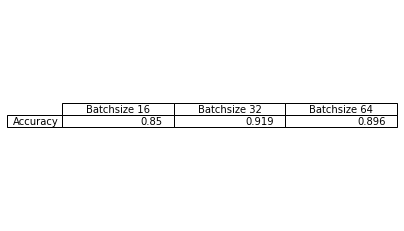

In [ ]:
#Table
fig, ax =plt.subplots(1,1)
data=[[0.850, 0.919,  0.896]]
column_labels=['Batchsize 16', 'Batchsize 32', 'Batchsize 64']
row_label = ['Accuracy']
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels,rowLabels=row_label, loc="center")
plt.style.use('classic')
plt.show()

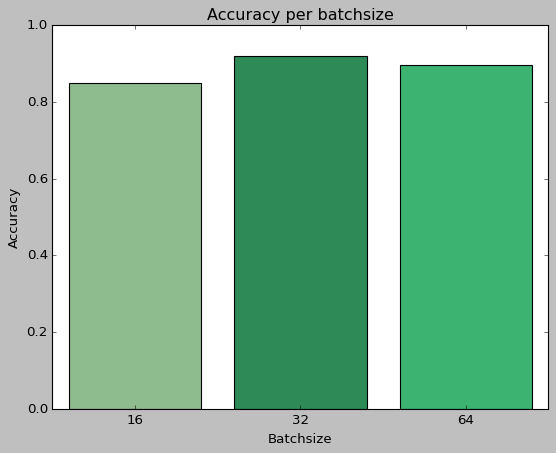

In [ ]:
#Barplot
# Make a random dataset:
height = [0.850, 0.919, 0.896]
bars = ('16', '32', '64')
x_pos = np.arange(len(bars))

# Create bars and choose color
plt.bar(x_pos, height, color = ['darkseagreen', 'seagreen', 'mediumseagreen'])
 
# Add title and axis names
plt.title('Accuracy per batchsize')
plt.xlabel('Batchsize')
plt.ylabel('Accuracy')

# Create names on the x axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

In [ ]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

def elastic_transform(image, alpha_range, sigma, random_state=None):
     
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))
    
    transformed_images = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return transformed_images

### Visualising the tuning

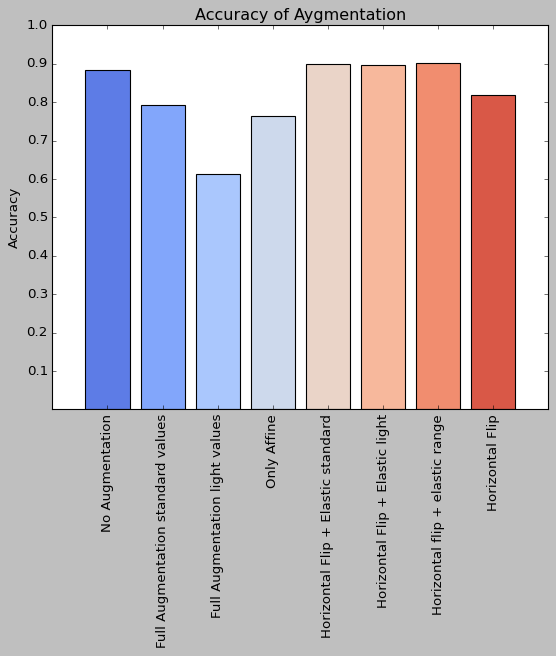

In [ ]:
# Accuracies
plt.style.use('classic')
height = [0.8830, 0.7917, 0.6132, 0.7631, 0.9005, 0.8957, 0.9008, 0.8193]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip')
x_pos = np.arange(len(bars))
#colours = sns.color_palette("coolwarm", 8)
# Create bars and choose color
plt.bar(x_pos, height, color = sns.color_palette("coolwarm", 8))
 
# Add title and axis names
plt.title('Accuracy of Aygmentation')
plt.ylabel('Accuracy')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

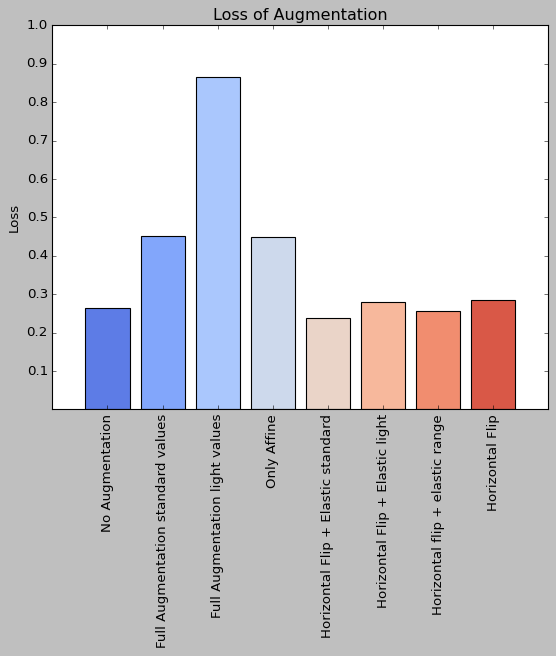

In [ ]:
plt.style.use('classic')
# Losses
# Accuracies
height = [0.2641, 0.4504, 0.8652, 0.4492, 0.2381, 0.2797, 0.2563, 0.2848]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip')

#colours = sns.color_palette("coolwarm", 8)

# Create bars and choose color
plt.bar(x_pos, height, color = sns.color_palette("coolwarm", 8))
 
# Add title and axis names
plt.title('Loss of Augmentation')
plt.ylabel('Loss')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15,horizontal_flip = True,
                             preprocessing_function = lambda x: elastic_transform(x,alpha_range =  [2,6],sigma = 2.5))

In [ ]:
train_generator = datagen.flow_from_dataframe(train,directory='./',x_col='image_path',y_col='Tumor',subset='training',
                                              class_mode='binary',batch_size=32,shuffle=True,target_size=(256,256))

Found 2404 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator = datagen.flow_from_dataframe(val,directory='./',x_col='image_path',y_col='Tumor',subset='validation',
                                              class_mode='binary',batch_size=32,shuffle=True,target_size=(256,256))

Found 106 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,directory='./',x_col='image_path',y_col='Tumor',class_mode='binary',batch_size=32,shuffle=False,target_size=(256,256))

Found 393 validated image filenames belonging to 2 classes.


In [ ]:
# Taking a pretrained base
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(256,256,3)))
pretrained_base.summary()  

# The pretrained database not trainable.
pretrained_base.trainable = False

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
# Attaching head
model = keras.Sequential([
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(name='Flatten'),layers.Dense(256, activation='relu'),layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),layers.Dropout(0.3),layers.Dense(1, activation='sigmoid'),])

## Train Model



In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0.001,mode='min', verbose=1, patience=20,restore_best_weights = True)

checkpointer = ModelCheckpoint(filepath="vgg16_1.h5",monitor = 'val_accuracy',verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=15,min_delta=0.0001,factor=0.2)

callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
history = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=callbacks)

## Evaluation of The Classification

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
# Accuracy of Test
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

13/13 [==============================] - 4s 278ms/step - loss: 0.4517 - accuracy: 0.7583
Test accuracy : 75.8269727230072 %


In [ ]:
#Save model
model.save('model.h5')

#SEGMENTATION MODEL

In [ ]:
#Data Generation, Data Augmentation, & Modify the data
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

* **the Dice coefficient** a metric used to evaluate the performance of a binary classifier.
* **The dice_coef_loss function** calculates the loss associated with a Dice coefficient, which is a measure of similarity between two sets. 
* **The IOU function** calculates the Intersection over Union (IoU) metric, which is a measure of how much overlap there is between two sets.
* **The jac_distance function** calculates the Jaccard distance, which is a measure of dissimilarity between two sets.

In [ ]:
smooth=100  #The smooth parameter is added to avoid division by zero errors.

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

 
 ## UNet Model

In [ ]:
def unet(input_size=(256,256,3)):
    
    # Input
    inputs = Input(input_size)
    
    # Stage 1 
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    # Stage 2
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    # Stage 3
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    # Stage 4
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    # Stage 5
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    # Upstage 1
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    # Upstage 2
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    # Upstage 3
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    # Upstage 4
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    # Output 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#Setting the hyperparameters 
EPOCHS = 50
BATCH_SIZE = 32
im_height = 256
im_width = 256


##Data Augmentation

In [ ]:
train_generator_args = dict(width_shift_range=0.05,height_shift_range=0.05,zoom_range=0.05,horizontal_flip=True,fill_mode='nearest')

train_gen = train_generator(train, BATCH_SIZE,train_generator_args,target_size=(im_height, im_width))
    
test_gener = train_generator(val, BATCH_SIZE,dict(),target_size=(im_height, im_width))

In [ ]:
checkpointer2 = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

callbacks = [checkpointer2, earlystopping, reduce_lr]

In [ ]:
#Training the model
model = unet(input_size=(im_height, im_width, 3))

model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch = len(train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = test_gener,
                    validation_steps = len(val) / BATCH_SIZE,
                    callbacks = callbacks)

##Evaluation of the Segmentation model

In [ ]:
history = history.history

list_traindice = history['dice_coef']
list_valdice = history['val_dice_coef']

list_trainjaccard = history['iou']
list_valjaccard = history['val_iou']

list_trainloss = history['loss']
list_valloss = history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list_valloss, 'b-', label='validation loss')
plt.plot(list_trainloss,'r-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss graph', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(list_valdice, 'b-', label= 'validation_dice_coef')
plt.plot(list_traindice, 'r-', label= 'train_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Dice coefficient', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(test, BATCH_SIZE,dict(),target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(test) / BATCH_SIZE)

print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 9s 741ms/step - loss: -0.7424 - binary_accuracy: 0.9955 - iou: 0.6044 - dice_coef: 0.7467
Test lost:  -0.7423549890518188
Test IOU:  0.9954546093940735
Test Dice Coefficent:  0.6044367551803589


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


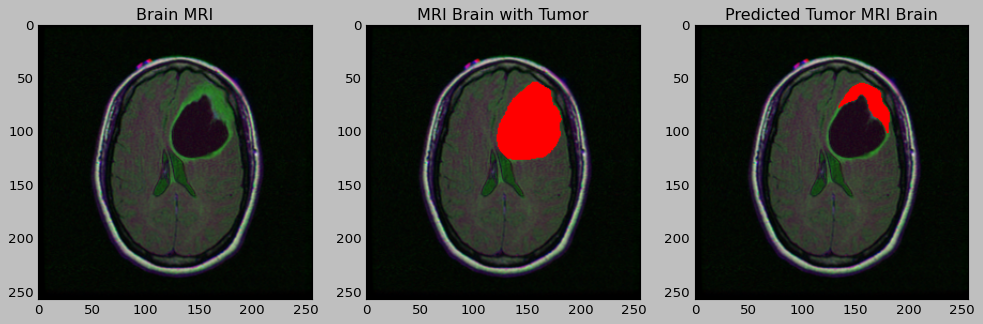

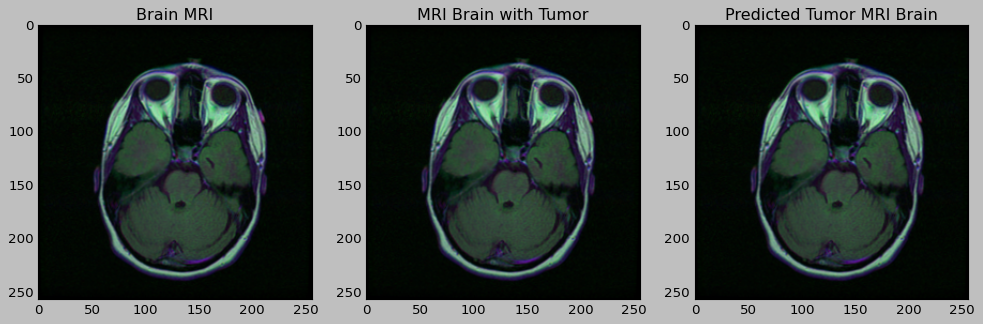

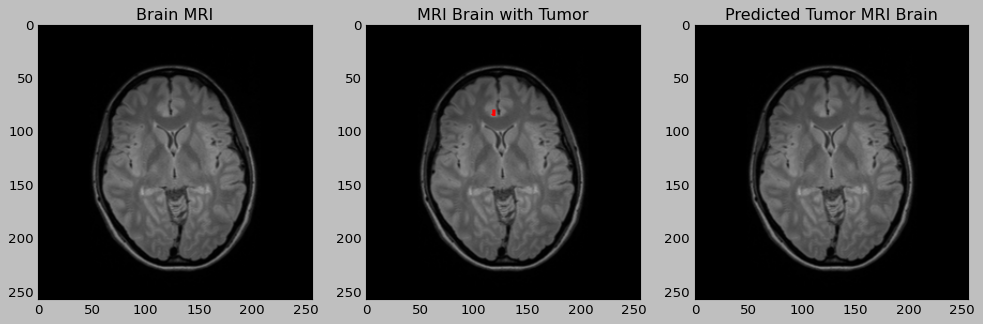

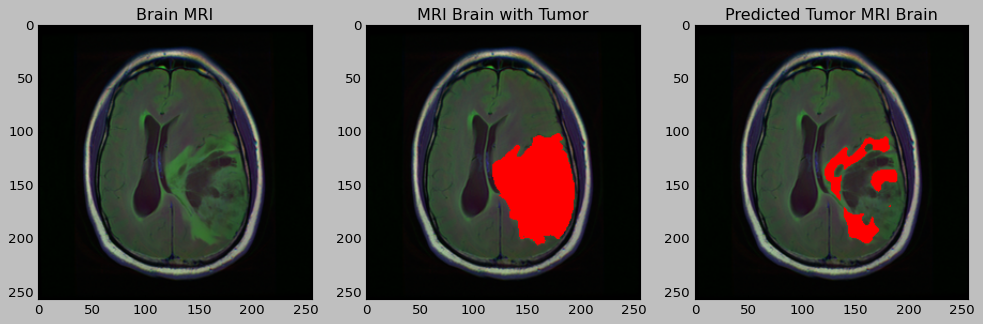

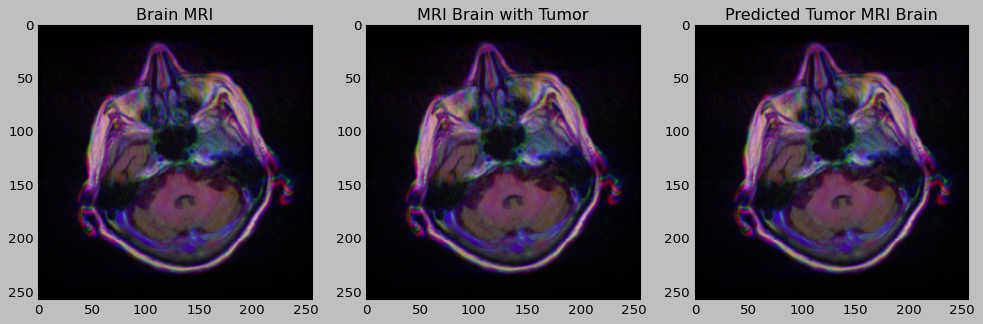

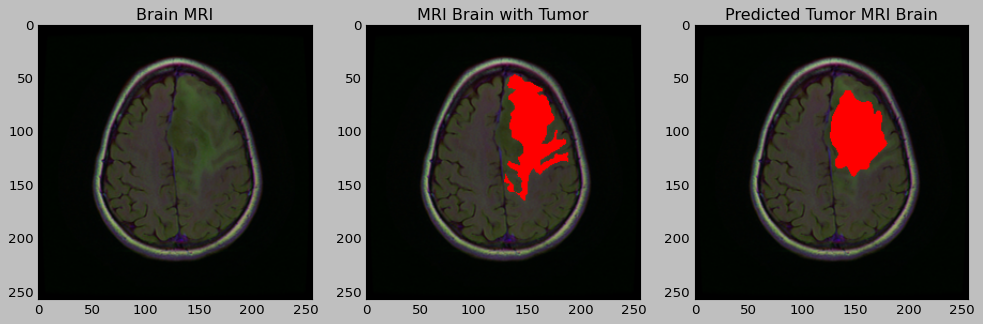

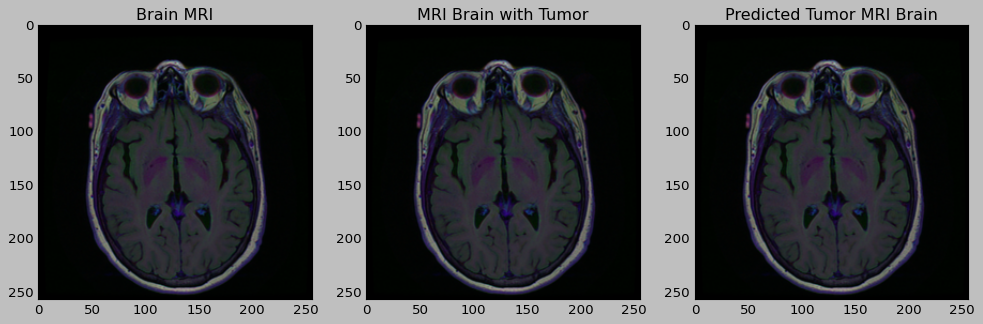

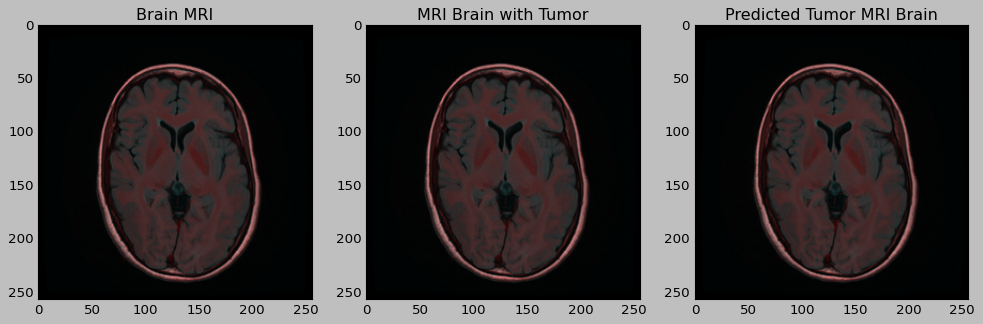

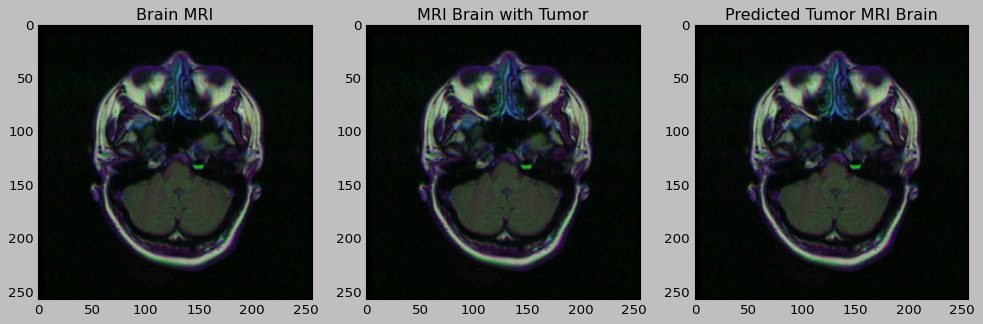

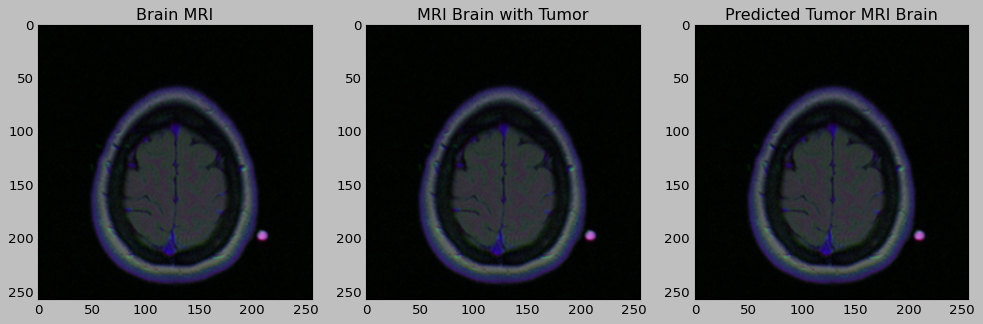

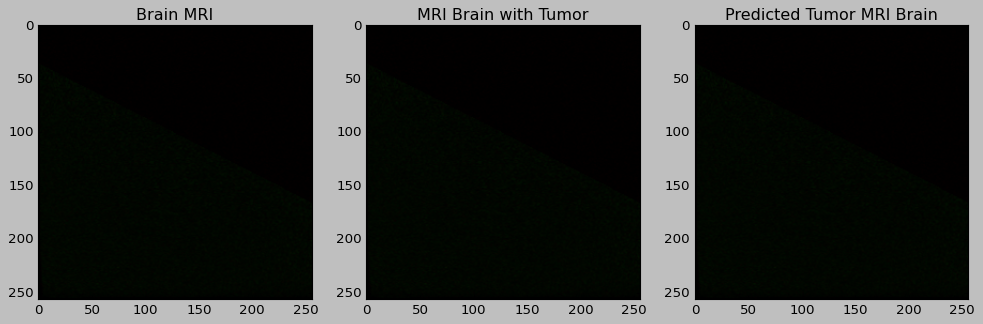

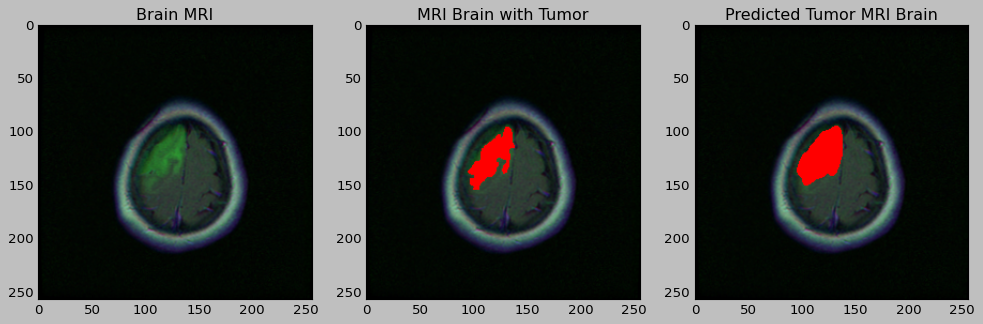

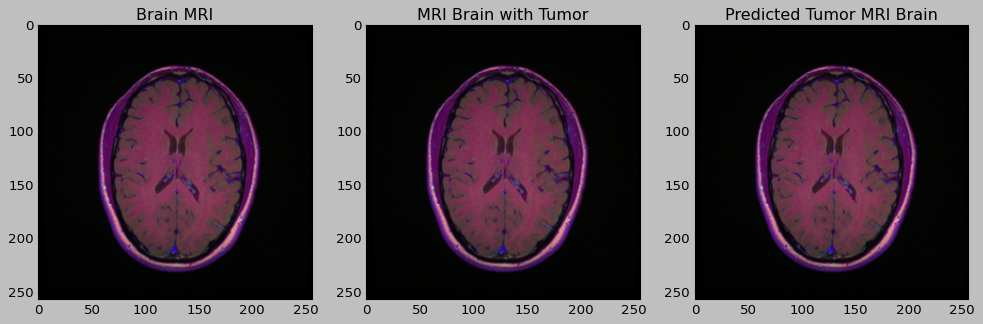

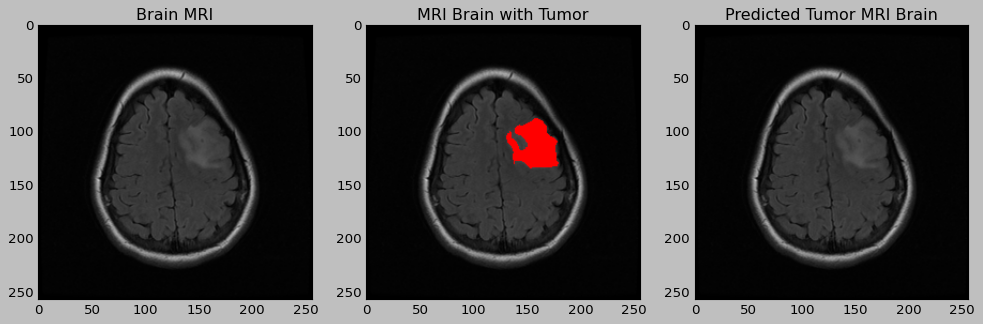

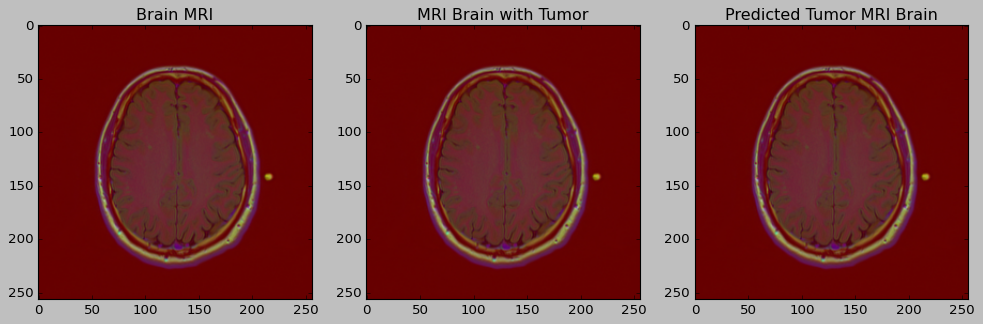

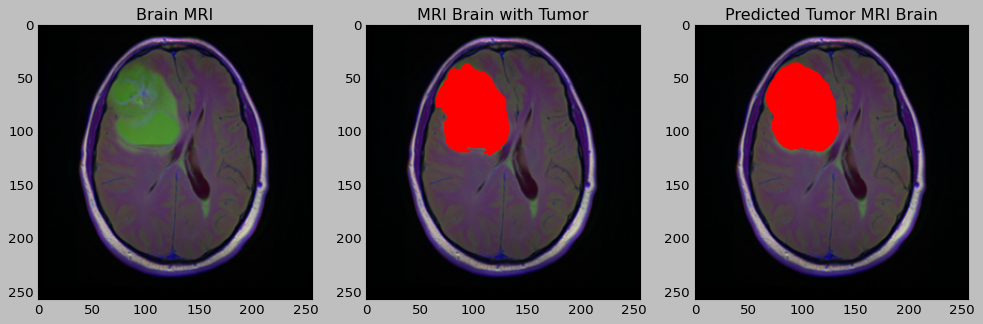

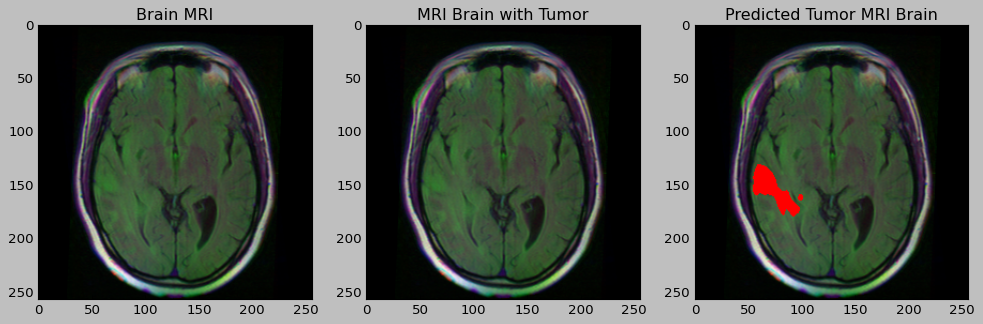

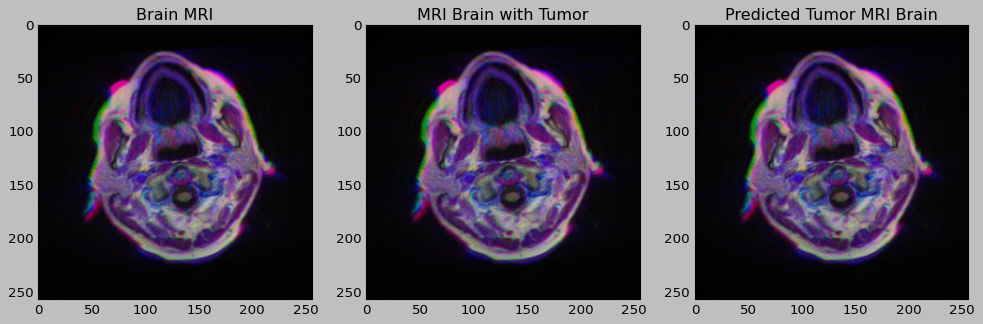

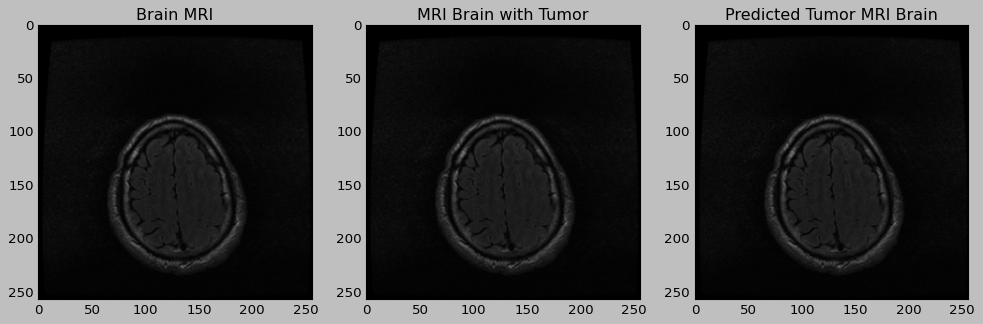

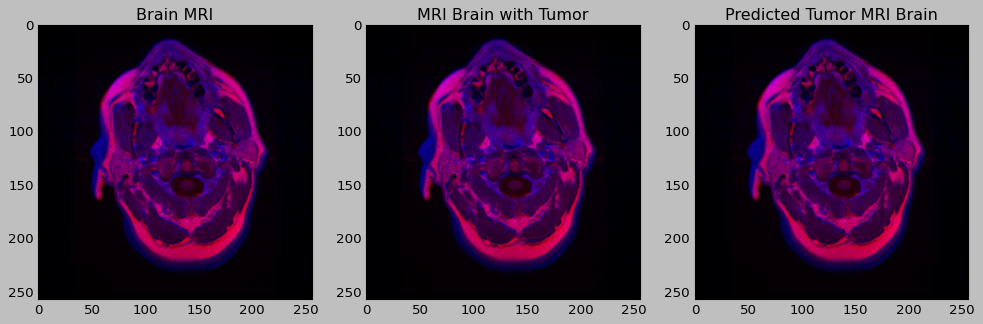

In [ ]:
for i in range(1,40,2):
    img_path_test = test.iloc[i, 0]
    msk_path_test = test.iloc[i, 1]
    img = cv2.imread(img_path_test)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    msk= cv2.imread(msk_path_test)
    pred = model.predict(img) #predictions
    img = np.squeeze(img)

    #Plot the Brain MRI scans 
    original = img.copy()
    fig, ax = plt.subplots(1,3, figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path_test)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[1].imshow(np.squeeze(sample_over_gt))
    ax[1].set_title("MRI Brain with Tumor")
    
    #Plot the predicted mask on the Brain MRI Scan
    main = original.copy()
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(main, contours, -1, [255,0,0], thickness=-1)
    ax[2].imshow(np.squeeze(sample_over_pr))
    ax[2].set_title("Predicted Tumor MRI Brain")

In [ ]:
#segmentation model
model.save('model.h5')